# **Lung Cancer Histology Prediction using RNA Sequencing Data**


This project was inspired by the paper "[Deep Radiotranscriptomics of Non-Small Cell Lung Carcinoma for Assessing Molecular and Histology Subtypes with a Data-Driven Analysis](https://doi.org/10.3390/diagnostics11122383)" by E. Trivizakis *et al*. The paper developed and evaluated a "deep radiotranscriptomics" framework for non-small cell lung carcinoma (NSCLC) that combined two types of data: deep features extracted from CT images and transcriptomic (RNA) data.

## Background

Non-small cell lung cancer (NSCLC) is the most common type of lung cancer. The main types of NSCLC include adenocarcinoma, squamous cell carcinoma, and large cell lung cancer. While the original paper used deep learning to predict tumor histology (the cellular composition of the cancerous tumor), this project explores unsupervised learning approaches.

## Data Sources

This project uses data from the following sources:
- [RNA Sequence Data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE103584)
- [Clinical Data](https://www.cancerimagingarchive.net/collection/nsclc-radiogenomics/)

## Project Objectives

The primary objective is to implement unsupervised learning algorithms to predict NSCLC histology (specifically distinguishing between adenocarcinoma and squamous cell carcinoma). This approach allows us to evaluate whether gene expression patterns naturally cluster according to histological subtypes without explicit labels.

## Project Structure

This notebook is organized into the following sections:

1. **Data Loading and Preprocessing**
    - Loading RNA sequencing and clinical data
    - Handling missing values
   
2. **Exploratory Data Analysis (EDA)**
    - Distribution of histological subtypes
    - Gene expression patterns across subtypes
    - Correlation analysis between key genes

3. **Dimension Reduction with PCA**
    - Normalization
    - Reducing high-dimensional gene expression data

4. **Unsupervised Learning & Visualization**
    - Methods implemented:
        - K-means clustering
        - Hierarchical clustering
        - Non-negative Matrix Factorization (NMF)
    - Evaluation of clustering performance against known histology labels
    - t-SNE plots of clusters vs. true histology
    - Comparison of clustering methods

6. **Discussion and Conclusions**
    - Performance comparison across methods


---
---
## **0. Import Library**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
from scipy.optimize import linear_sum_assignment
import itertools


---
---
## **1. Data Loading and Preprocessing**

For this analysis, I used data from two primary sources:
- [RNA Sequence Data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE103584):
    - File: ``GSE103584_R01_NSCLC_RNAseq.txt``
    - Format: Tab-delimited text file with patient IDs and RNA expression values (22126 rows x 131 columns)
    - Processing: The data was transposed to place each patient's record in a row, with genes as columns
- [Clinical Data](https://www.cancerimagingarchive.net/collection/nsclc-radiogenomics/):
    - File: ``NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv``
    - Contents: Patient demographics, exposure history, follow-up information, treatment details, and molecular test results including histological classification (211 rows x 40 columns)

Data preprocessing workflow consisted of the following steps:
- Data Integration:
    - Merged RNA sequencing data with clinical information using patient IDs as the common identifier
    - Created a unified dataset containing both genomic and clinical features for each patient
- Handling Missing Values:
    - Identified and quantified missing values across all variables
    - Removed columns (features) with missing data.

In [3]:
gene_expression_file = "GSE103584_R01_NSCLC_RNAseq.txt"
histology_file = "NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv"
output_file = "gene_expression_with_histology.csv"

In [33]:
df = pd.read_csv(gene_expression_file, sep='\t')
print(df.shape)

# The first row contains patient IDs
# First column doesn't have a name
gene_df = df.rename(columns={df.columns[0]: 'gene'})
gene_df = gene_df.set_index('gene')
gene_df_t = gene_df.transpose()

gene_df_t = gene_df_t.reset_index()
gene_df_t = gene_df_t.rename(columns={'index': 'patient_id'})
gene_df_t

(22126, 131)


gene,patient_id,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
0,R01-023,NaN,NaN,NaN,NaN,2.034380,59.5255,NaN,NaN,2.475232,...,NaN,2.647025,0.987489,12.505150,NaN,3.472997,11.285434,9.602287,60.781455,NaN
1,R01-024,NaN,2.528510,NaN,NaN,0.436761,31.7306,2.374324,NaN,2.588888,...,3.595700,0.820777,1.117200,12.965631,NaN,5.126819,10.920210,5.065447,50.243009,2.237496
2,R01-006,NaN,1.713994,NaN,NaN,1.601030,40.8846,0.477936,NaN,1.908870,...,1.715370,4.313210,1.908360,16.919100,NaN,5.544750,5.967490,5.518227,77.056216,NaN
3,R01-153,NaN,3.143938,0.646213,NaN,3.366031,93.2069,NaN,NaN,1.479920,...,5.426810,2.305033,1.826140,17.253040,NaN,3.876170,26.631100,12.130147,77.235453,NaN
4,R01-031,NaN,1.795080,NaN,NaN,0.994382,27.9210,NaN,NaN,1.828780,...,3.543730,0.977787,2.264630,14.226541,NaN,7.175560,14.111400,11.410494,81.196830,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,R01-141,NaN,2.094170,1.304690,NaN,NaN,142.1040,NaN,NaN,2.711100,...,6.356400,1.627650,1.543680,16.328380,NaN,94.510210,8.754060,9.005920,68.392210,NaN
126,R01-142,NaN,1.944550,1.055700,NaN,NaN,233.7730,NaN,1.622167,2.869876,...,NaN,1.874630,3.660330,6.604060,NaN,62.094580,21.238980,7.571560,71.528003,NaN
127,R01-144,NaN,NaN,0.939564,NaN,NaN,153.0460,NaN,NaN,1.163060,...,1.646760,2.613970,4.277221,12.545441,NaN,79.505468,12.383909,2.859420,50.273287,NaN
128,R01-145,NaN,6.130287,1.445220,NaN,NaN,192.5240,NaN,0.340432,3.440720,...,3.500085,1.745628,1.423690,5.496585,1.05644,71.244270,24.413600,8.594376,55.254989,NaN


In [34]:
# Loading histology data
df = pd.read_csv(histology_file)
print(df.shape)

histology_df = df[['Case ID', 'Histology ']]
histology_df = histology_df.rename(columns={'Histology ': 'Histology'})
histology_df = histology_df.rename(columns={'Case ID': 'patient_id'})

histology_df

(211, 40)


,patient_id,Histology
0,AMC-001,Adenocarcinoma
1,AMC-002,Adenocarcinoma
2,AMC-003,Adenocarcinoma
3,AMC-004,Adenocarcinoma
4,AMC-005,Adenocarcinoma
...,...,...
206,R01-159,Squamous cell carcinoma
207,R01-160,Adenocarcinoma
208,R01-161,Adenocarcinoma
209,R01-162,Adenocarcinoma


In [6]:
common_patients = set(gene_df_t['patient_id']).intersection(set(histology_df['patient_id']))
print(f"Number of common patients: {len(common_patients)}")

merged_df = pd.merge(gene_df_t, histology_df, on='patient_id', how='inner')
print(f"Final dataset has {merged_df.shape[0]} patients and {merged_df.shape[1]} features (including patient_id and histology)")
merged_df

Number of common patients: 130
Final dataset has 130 patients and 22128 features (including patient_id and histology)


,patient_id,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR,Histology
0,R01-023,NaN,NaN,NaN,NaN,2.034380,59.5255,NaN,NaN,2.475232,...,2.647025,0.987489,12.505150,NaN,3.472997,11.285434,9.602287,60.781455,NaN,Adenocarcinoma
1,R01-024,NaN,2.528510,NaN,NaN,0.436761,31.7306,2.374324,NaN,2.588888,...,0.820777,1.117200,12.965631,NaN,5.126819,10.920210,5.065447,50.243009,2.237496,Adenocarcinoma
2,R01-006,NaN,1.713994,NaN,NaN,1.601030,40.8846,0.477936,NaN,1.908870,...,4.313210,1.908360,16.919100,NaN,5.544750,5.967490,5.518227,77.056216,NaN,Adenocarcinoma
3,R01-153,NaN,3.143938,0.646213,NaN,3.366031,93.2069,NaN,NaN,1.479920,...,2.305033,1.826140,17.253040,NaN,3.876170,26.631100,12.130147,77.235453,NaN,Adenocarcinoma
4,R01-031,NaN,1.795080,NaN,NaN,0.994382,27.9210,NaN,NaN,1.828780,...,0.977787,2.264630,14.226541,NaN,7.175560,14.111400,11.410494,81.196830,NaN,NSCLC NOS (not otherwise specified)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,R01-141,NaN,2.094170,1.304690,NaN,NaN,142.1040,NaN,NaN,2.711100,...,1.627650,1.543680,16.328380,NaN,94.510210,8.754060,9.005920,68.392210,NaN,Adenocarcinoma
126,R01-142,NaN,1.944550,1.055700,NaN,NaN,233.7730,NaN,1.622167,2.869876,...,1.874630,3.660330,6.604060,NaN,62.094580,21.238980,7.571560,71.528003,NaN,Adenocarcinoma
127,R01-144,NaN,NaN,0.939564,NaN,NaN,153.0460,NaN,NaN,1.163060,...,2.613970,4.277221,12.545441,NaN,79.505468,12.383909,2.859420,50.273287,NaN,Adenocarcinoma
128,R01-145,NaN,6.130287,1.445220,NaN,NaN,192.5240,NaN,0.340432,3.440720,...,1.745628,1.423690,5.496585,1.05644,71.244270,24.413600,8.594376,55.254989,NaN,Adenocarcinoma


In [31]:
merged_df.to_csv(output_file, index=False)

In [7]:
missing_data = merged_df.isnull().sum()# / len(df_balanced_dropped) * 100
dtypes = merged_df.dtypes
info_df = pd.DataFrame({'Data Type': dtypes, 'Missing Any': missing_data})

info_df.sort_values('Missing Any', ascending=False, inplace=True)
print(info_df.head(15000))

           Data Type  Missing Any
LOC613038    float64          130
KRTAP10-12   float64          130
KRTAP10-8    float64          130
KRTAP10-7    float64          130
KRTAP10-6    float64          130
...              ...          ...
MRPS17       float64            2
MRPS2        float64            2
MTIF2        float64            2
DNAJC9       float64            2
DNHD1        float64            2

[15000 rows x 2 columns]


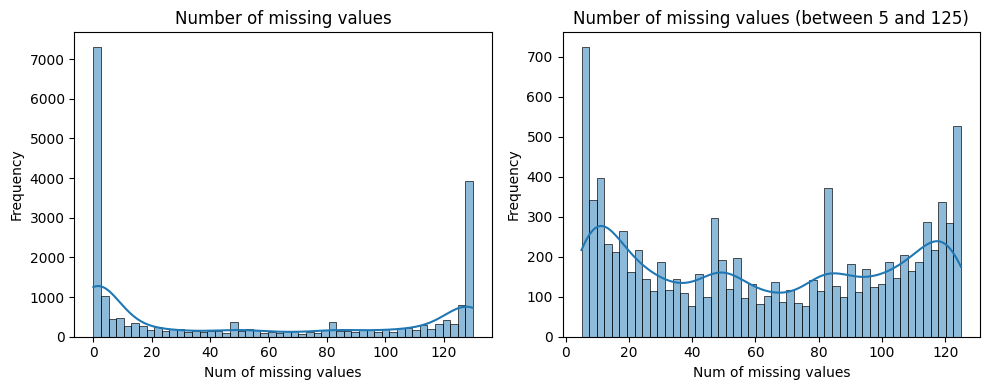

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(info_df['Missing Any'], bins=50, kde=True)
plt.title('Number of missing values')
plt.xlabel('Num of missing values')
plt.ylabel('Frequency')

filtered_info_df = info_df[(info_df['Missing Any'] >= 5) & (info_df['Missing Any'] <= 125)]
plt.subplot(1, 2, 2)
sns.histplot(filtered_info_df['Missing Any'], bins=50, kde=True)
plt.title('Number of missing values (between 5 and 125)')
plt.xlabel('Num of missing values')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [8]:
cleaned_df = merged_df.dropna(axis=1)
print(f"Cleaned_df shape: {cleaned_df.shape}")

Cleaned_df shape: (130, 5270)


---
---
## **2. Exploratory Data Analysis (EDA)**
- Distribution of histological subtypes
- Gene expression patterns across subtypes
- Correlation analysis between key genes

Total number of patients: 130

Histology distribution:
Adenocarcinoma                         96
Squamous cell carcinoma                31
NSCLC NOS (not otherwise specified)     3
Name: Histology, dtype: int64


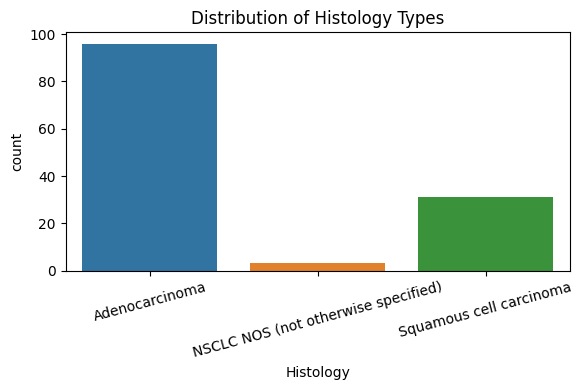

In [9]:
print(f"Total number of patients: {cleaned_df.shape[0]}")

print("\nHistology distribution:")
histology_counts = cleaned_df['Histology'].value_counts()
print(histology_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='Histology', data=cleaned_df)
plt.title('Distribution of Histology Types')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



Updated Histology Distribution:
Adenocarcinoma: 96 (75.6%)
Squamous cell carcinoma: 31 (24.4%)


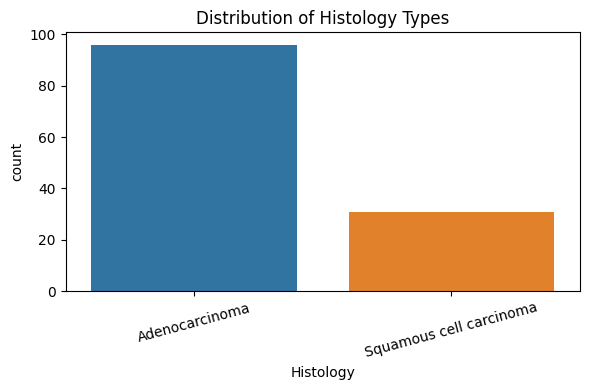

In [9]:
cleaned_df = cleaned_df[cleaned_df['Histology'] != 'NSCLC NOS (not otherwise specified)']

print("\nUpdated Histology Distribution:")
histology_counts = cleaned_df['Histology'].value_counts()
histology_percent = cleaned_df['Histology'].value_counts(normalize=True) * 100
for histology, count in histology_counts.items():
    percent = histology_percent[histology]
    print(f"{histology}: {count} ({percent:.1f}%)")

plt.figure(figsize=(6, 4))
sns.countplot(x='Histology', data=cleaned_df)
plt.title('Distribution of Histology Types')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [10]:
print("\nGene expression summary statistics:")
gene_columns = [col for col in cleaned_df.columns if col not in ['patient_id', 'Histology']]
gene_stats = cleaned_df[gene_columns].describe().T
print(f"Number of genes: {len(gene_columns)}")
print(f"Mean expression across all genes: {cleaned_df[gene_columns].values.mean():.4f}")
print(f"Median expression across all genes: {np.median(cleaned_df[gene_columns].values):.4f}")
print(f"Min expression: {cleaned_df[gene_columns].values.min():.4f}")
print(f"Max expression: {cleaned_df[gene_columns].values.max():.4f}")


Gene expression summary statistics:
Number of genes: 5268
Mean expression across all genes: 19230.9453
Median expression across all genes: 12.4699
Min expression: 0.3365
Max expression: 2240000011.0000


Plotting distribution for gene columns:

Mean expression by histology type:
Histology
Adenocarcinoma             19716.123087
Squamous cell carcinoma    17728.459114
dtype: float64


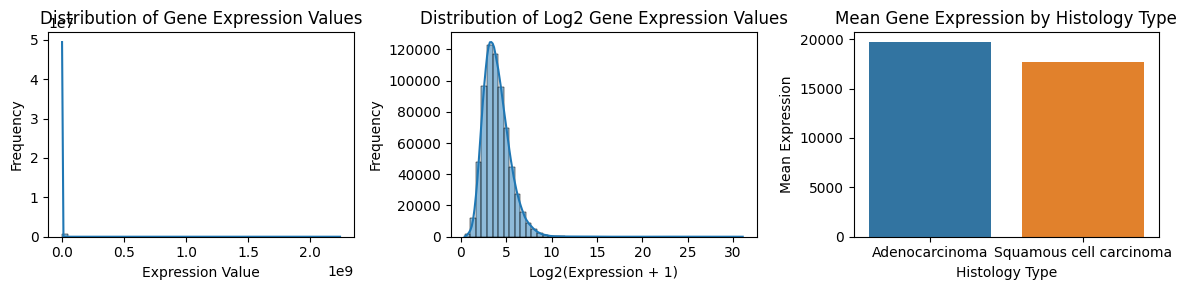

In [11]:
print(f"Plotting distribution for gene columns:")
plt.figure(figsize=(12, 3))
    
all_expressions = cleaned_df[gene_columns].values.flatten()

plt.subplot(1, 3, 1)
sns.histplot(all_expressions, bins=50, kde=True)
plt.title('Distribution of Gene Expression Values')
plt.xlabel('Expression Value')
plt.ylabel('Frequency')

# Log-transformed distribution (often more informative for gene expression)
plt.subplot(1, 3, 2)
log_expressions = np.log2(all_expressions + 1)  # Add 1 to avoid log(0)
sns.histplot(log_expressions, bins=50, kde=True)
plt.title('Distribution of Log2 Gene Expression Values')
plt.xlabel('Log2(Expression + 1)')
plt.ylabel('Frequency')

# Expression by histology type
print("\nMean expression by histology type:")
histology_means = cleaned_df.groupby('Histology')[gene_columns].mean()
print(histology_means.mean(axis=1))

plt.subplot(1, 3, 3)
sns.barplot(x=histology_means.index, y=histology_means.mean(axis=1))
plt.title('Mean Gene Expression by Histology Type')
plt.xlabel('Histology Type')
plt.ylabel('Mean Expression')
plt.tight_layout()
plt.show()


Top 20 genes with highest expression variance between histology types:
CHD7        2.427539e+14
APP         1.057321e+14
MIB1        4.527835e+13
ZNF121      3.821074e+13
SETD3       2.583757e+13
TOR1AIP1    9.845848e+12
SEC22A      5.959776e+12
SYPL1       2.983186e+12
SNX3        1.549524e+12
MAPKAP1     1.500354e+12
HECTD1      1.354398e+12
TRAPPC8     8.788788e+11
CD2AP       4.589236e+11
ZC3HAV1     3.683692e+11
DNM2        3.463560e+11
ZFYVE26     3.082009e+11
USP32       2.580180e+11
ACSL3       2.495321e+11
SNF8        2.392020e+11
DNAJC13     2.320472e+11
dtype: float64


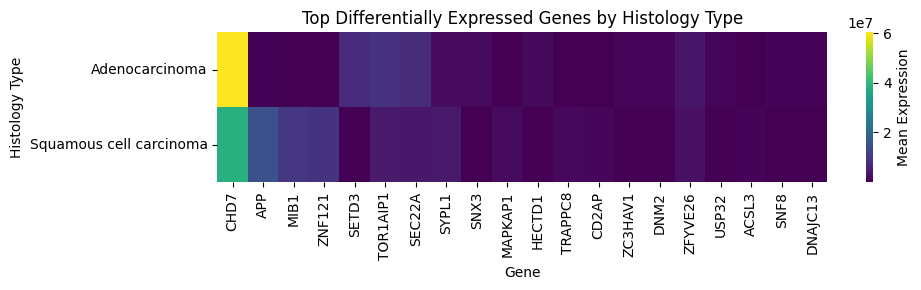

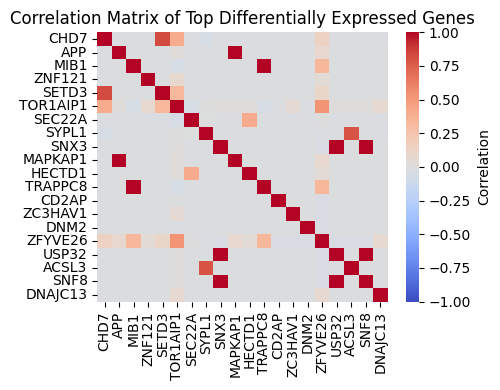


Highly correlated gene pairs (|r| > 0.8):
SNX3     SNF8       1.000000
SNF8     SNX3       1.000000
MIB1     TRAPPC8    1.000000
TRAPPC8  MIB1       1.000000
USP32    SNF8       1.000000
SNF8     USP32      1.000000
SNX3     USP32      1.000000
USP32    SNX3       1.000000
APP      MAPKAP1    0.997657
MAPKAP1  APP        0.997657
CHD7     SETD3      0.827975
SETD3    CHD7       0.827975
dtype: float64


In [12]:
variance_between_groups = histology_means.var(axis=0)

top_genes = variance_between_groups.sort_values(ascending=False).head(20)
print("\nTop 20 genes with highest expression variance between histology types:")
print(top_genes)

# Plot heatmap of top differentially expressed genes
plt.figure(figsize=(10, 3))
top_gene_names = top_genes.index
sns.heatmap(histology_means[top_gene_names], annot=False, cmap='viridis', 
            cbar_kws={'label': 'Mean Expression'})
plt.title('Top Differentially Expressed Genes by Histology Type')
plt.ylabel('Histology Type')
plt.xlabel('Gene')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

corr_matrix = cleaned_df[top_gene_names].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix of Top Differentially Expressed Genes')
plt.tight_layout()
plt.show()

corr_unstack = corr_matrix.unstack()
corr_unstack = corr_unstack[corr_unstack < 1.0]  # Remove self-correlations
high_corr = corr_unstack[abs(corr_unstack) > 0.8].sort_values(ascending=False)
if len(high_corr) > 0:
    print("\nHighly correlated gene pairs (|r| > 0.8):")
    print(high_corr)
else:
    print("\nNo gene pairs with correlation > 0.8 found.")

    

---
---
## **3. Dimension Reduction with PCA**
- Normalization
- Reducing high-dimensional gene expression data

In [13]:
X, y = cleaned_df[gene_columns], cleaned_df['Histology']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA reduced shape: {X_pca.shape} (explained variance: {np.sum(pca.explained_variance_ratio_):.2f})")

PCA reduced shape: (127, 103) (explained variance: 0.95)


---
---
## **4. Unsupervised Learning & Visualization**

### **4.1. Approach**

This section explores unsupervised learning approaches for predicting NSCLC histology subtypes from gene expression data. The analysis integrates multiple clustering methods with varying number of clusters to identify natural patterns that correspond to known histological classifications.

### **4.2. Methods**

#### 4.2.1. Data Balancing Strategies
To address class imbalance in the dataset, three approaches were evaluated:
- **No Sampling** (original imbalanced distribution)
- **Oversampling** with Synthetic Minority Over-sampling Technique (SMOTE)
- **Undersampling** with Random Undersampling

#### 4.2.2. Clustering Algorithms
Three unsupervised learning algorithms were implemented:
- **K-means Clustering**: A centroid-based approach that partitions data into k clusters
- **Hierarchical Clustering**: An agglomerative method that builds nested clusters
- **Non-negative Matrix Factorization (NMF)**: A matrix decomposition technique that extracts meaningful patterns

#### 4.2.3. Semi-supervised Evaluation Framework
Initial experiments revealed limitations in traditional unsupervised approaches with fixed cluster numbers (k=2) for histology prediction. To address this, I developed a semi-supervised framework:

1. **Expanded Clustering**: Varied cluster counts (k=2,3,5,7,9,15) to capture more granular expression patterns
2. **Optimal Mapping**: Determined the best cluster-to-histology mapping using training data accuracy
3. **Independent Evaluation**: Applied this mapping to test data to assess generalizability
4. **Visualization**: Used t-SNE to project high-dimensional data into 2D space for visual comparison

This approach maintains the unsupervised nature of cluster discovery while leveraging limited label information to evaluate biological relevance. It allows for capturing potential subgroups within histological categories that may have distinct genomic signatures.

### **4.3. Implementation**

The framework is implemented through a set of functions:
- `apply_sampling`: Handles data balancing with SMOTE or undersampling
- `apply_clustering`: Applies the selected clustering algorithm with specified parameters
- `evaluate_clustering_accuracy`: Determines optimal cluster-to-histology mappings and calculates performance metrics
- `visualize_clusters`: Creates t-SNE projections for visual comparison across methods
- `run_experiments`: Orchestrates the entire experimental workflow across all combinations

Results are systematically compiled for comparative analysis across methods, sampling strategies, and cluster counts.



Running kmeans with n_clusters=2 and none sampling...

Evaluating accuracy for kmeans with n_clusters=2 and none sampling:
Train Accuracy: 0.6931818181818182, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Adenocarcinoma')

Running kmeans with n_clusters=3 and none sampling...

Evaluating accuracy for kmeans with n_clusters=3 and none sampling:
Train Accuracy: 0.6931818181818182, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma')

Running kmeans with n_clusters=5 and none sampling...

Evaluating accuracy for kmeans with n_clusters=5 and none sampling:
Train Accuracy: 0.7954545454545454, Test Accuracy: 0.9743589743589743, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma')

Running kmeans with n_clusters=7 and none sampling...

Evaluating accuracy for kmeans with n_clusters=7 and none sampling:
Train Accuracy: 0.7840909090909091, Test Accuracy: 0.8205128205128205, M

/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


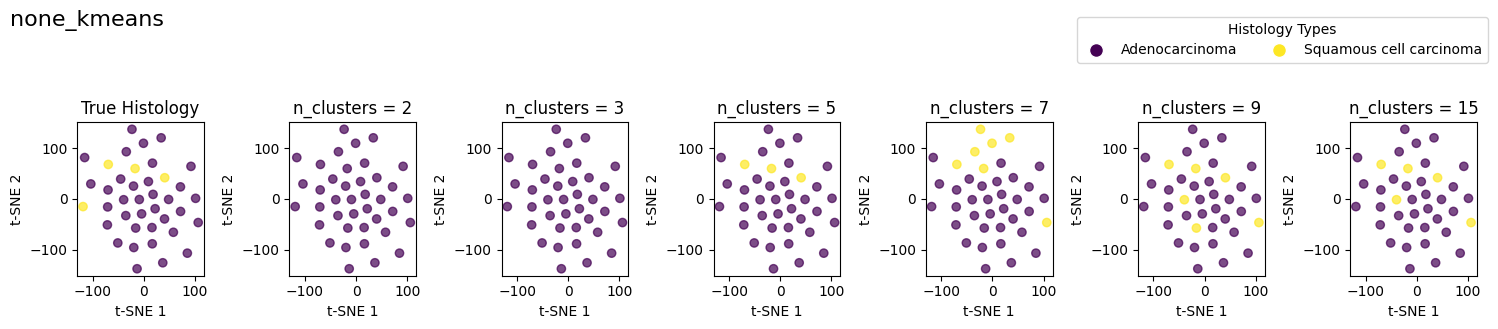


Running nmf with n_clusters=2 and none sampling...

Evaluating accuracy for nmf with n_clusters=2 and none sampling:
Train Accuracy: 0.6931818181818182, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Adenocarcinoma')

Running nmf with n_clusters=3 and none sampling...

Evaluating accuracy for nmf with n_clusters=3 and none sampling:
Train Accuracy: 0.6931818181818182, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma')

Running nmf with n_clusters=5 and none sampling...

Evaluating accuracy for nmf with n_clusters=5 and none sampling:
Train Accuracy: 0.6931818181818182, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma')

Running nmf with n_clusters=7 and none sampling...

Evaluating accuracy for nmf with n_clusters=7 and none sampling:
Train Accuracy: 0.7045454545454546, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Adeno

/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence

Train Accuracy: 0.7272727272727273, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma')

Running nmf with n_clusters=15 and none sampling...

Evaluating accuracy for nmf with n_clusters=15 and none sampling:


/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Train Accuracy: 0.7272727272727273, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma')


/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


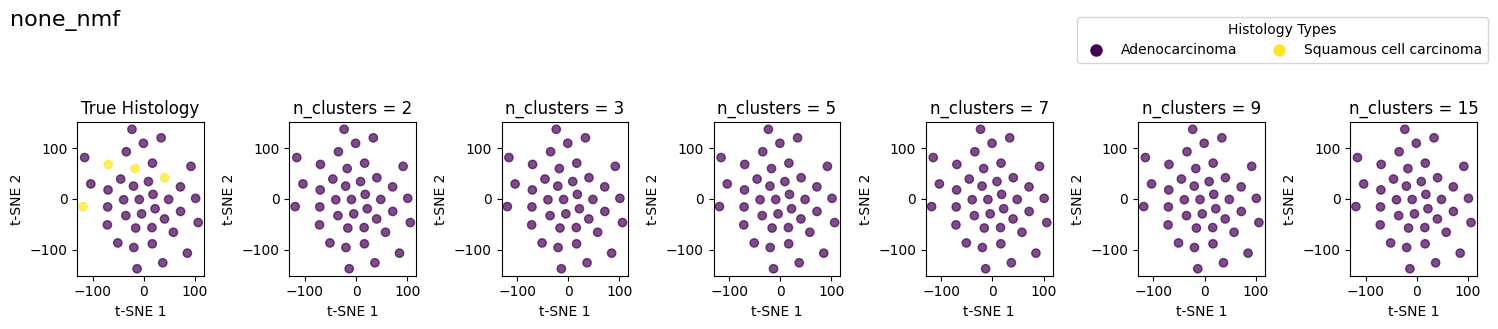


Running hierarchical with n_clusters=2 and none sampling...

Evaluating accuracy for hierarchical with n_clusters=2 and none sampling:
Train Accuracy: 0.6931818181818182, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Adenocarcinoma')

Running hierarchical with n_clusters=3 and none sampling...

Evaluating accuracy for hierarchical with n_clusters=3 and none sampling:
Train Accuracy: 0.6931818181818182, Test Accuracy: 0.8974358974358975, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma')

Running hierarchical with n_clusters=5 and none sampling...

Evaluating accuracy for hierarchical with n_clusters=5 and none sampling:
Train Accuracy: 0.7613636363636364, Test Accuracy: 0.6410256410256411, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma')

Running hierarchical with n_clusters=7 and none sampling...

Evaluating accuracy for hierarchical with n_clusters=7 and none sampling:
Train Accuracy: 0.761363

/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


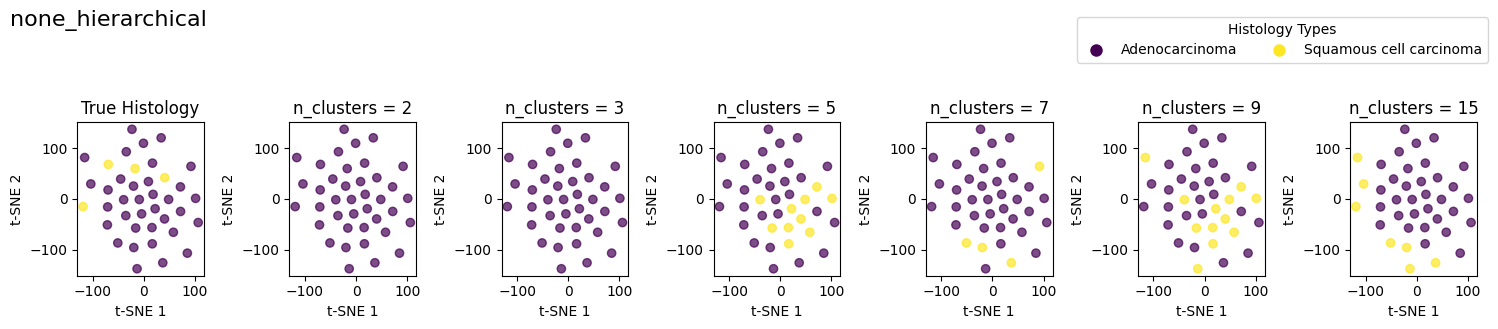

After oversample: (192, 103)
Class distribution after oversample: Adenocarcinoma             96
Squamous cell carcinoma    96
Name: Histology, dtype: int64

Running kmeans with n_clusters=2 and oversample sampling...

Evaluating accuracy for kmeans with n_clusters=2 and oversample sampling:
Train Accuracy: 0.5298507462686567, Test Accuracy: 0.4827586206896552, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma')

Running kmeans with n_clusters=3 and oversample sampling...

Evaluating accuracy for kmeans with n_clusters=3 and oversample sampling:
Train Accuracy: 0.6194029850746269, Test Accuracy: 0.6379310344827587, Mapping: ('Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma')

Running kmeans with n_clusters=5 and oversample sampling...

Evaluating accuracy for kmeans with n_clusters=5 and oversample sampling:
Train Accuracy: 0.7761194029850746, Test Accuracy: 0.7241379310344828, Mapping: ('Squamous cell carcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Adenocarcino

/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


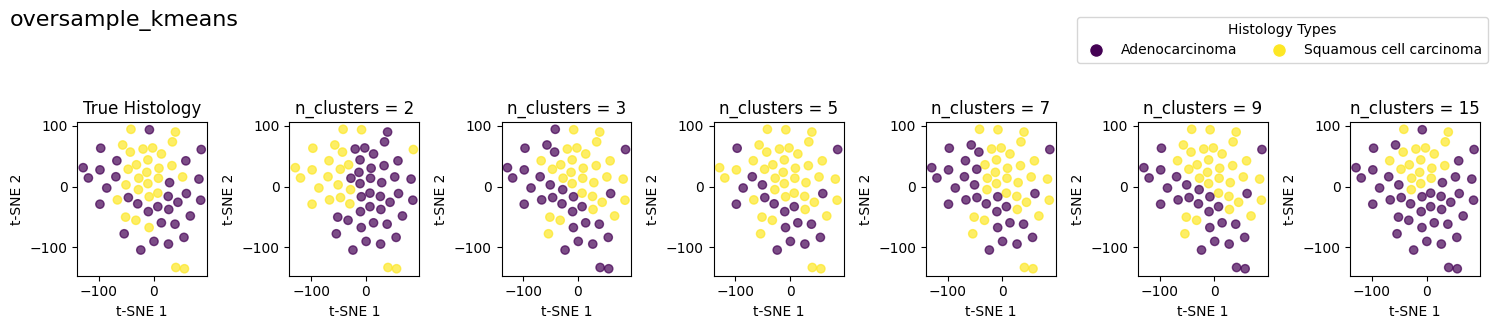


Running nmf with n_clusters=2 and oversample sampling...

Evaluating accuracy for nmf with n_clusters=2 and oversample sampling:
Train Accuracy: 0.5597014925373134, Test Accuracy: 0.5517241379310345, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma')

Running nmf with n_clusters=3 and oversample sampling...

Evaluating accuracy for nmf with n_clusters=3 and oversample sampling:
Train Accuracy: 0.5970149253731343, Test Accuracy: 0.603448275862069, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma')

Running nmf with n_clusters=5 and oversample sampling...

Evaluating accuracy for nmf with n_clusters=5 and oversample sampling:
Train Accuracy: 0.746268656716418, Test Accuracy: 0.8103448275862069, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma')

Running nmf with n_clusters=7 and oversample sampling...

Evaluating accuracy for nmf with n_clusters=7 and oversample sampli

/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence

Train Accuracy: 0.7985074626865671, Test Accuracy: 0.8793103448275862, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma')

Running nmf with n_clusters=9 and oversample sampling...

Evaluating accuracy for nmf with n_clusters=9 and oversample sampling:


/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Train Accuracy: 0.8059701492537313, Test Accuracy: 0.8793103448275862, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma')

Running nmf with n_clusters=15 and oversample sampling...

Evaluating accuracy for nmf with n_clusters=15 and oversample sampling:


/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Train Accuracy: 0.8283582089552238, Test Accuracy: 0.9137931034482759, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma')


/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


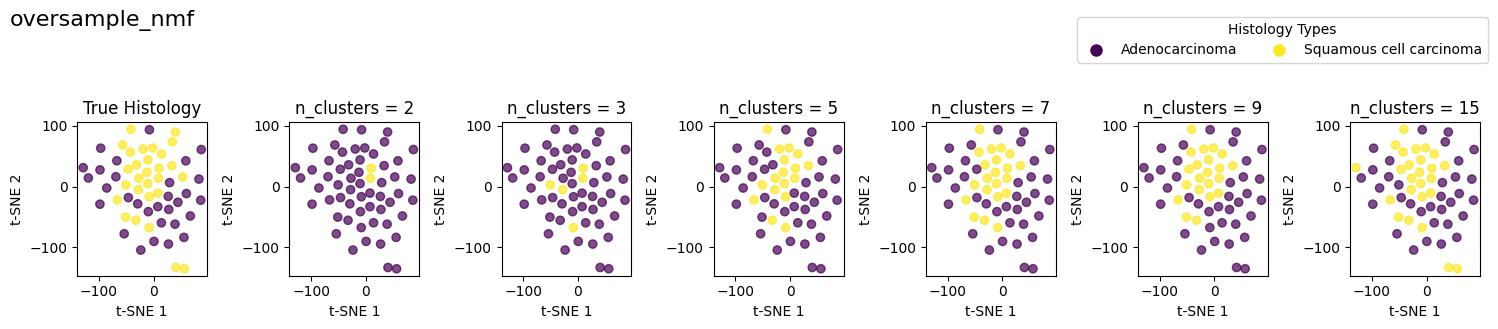


Running hierarchical with n_clusters=2 and oversample sampling...

Evaluating accuracy for hierarchical with n_clusters=2 and oversample sampling:
Train Accuracy: 0.5970149253731343, Test Accuracy: 0.603448275862069, Mapping: ('Squamous cell carcinoma', 'Adenocarcinoma')

Running hierarchical with n_clusters=3 and oversample sampling...

Evaluating accuracy for hierarchical with n_clusters=3 and oversample sampling:
Train Accuracy: 0.7238805970149254, Test Accuracy: 0.39655172413793105, Mapping: ('Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma')

Running hierarchical with n_clusters=5 and oversample sampling...

Evaluating accuracy for hierarchical with n_clusters=5 and oversample sampling:
Train Accuracy: 0.753731343283582, Test Accuracy: 0.29310344827586204, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma')

Running hierarchical with n_clusters=7 and oversample sampling...

Evaluating accuracy 

/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


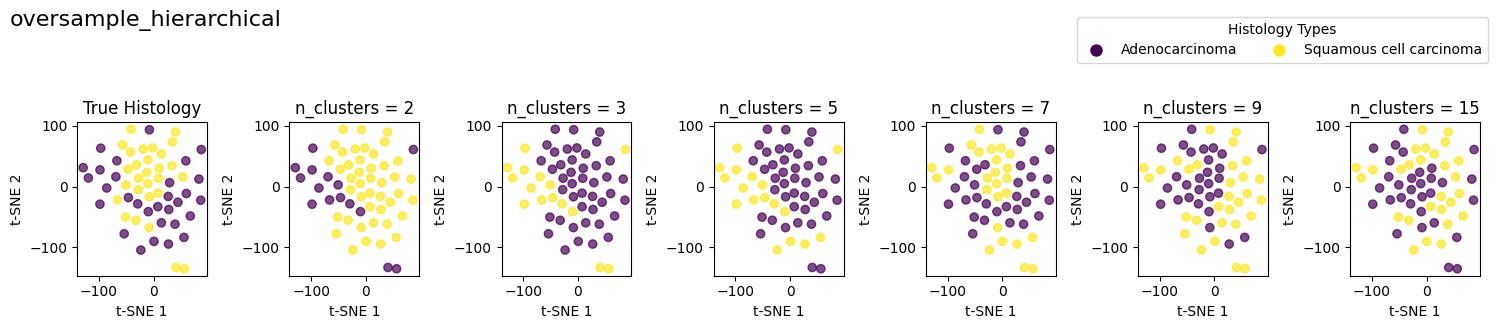

After undersample: (62, 103)
Class distribution after undersample: Adenocarcinoma             31
Squamous cell carcinoma    31
Name: Histology, dtype: int64

Running kmeans with n_clusters=2 and undersample sampling...

Evaluating accuracy for kmeans with n_clusters=2 and undersample sampling:
Train Accuracy: 0.5581395348837209, Test Accuracy: 0.6842105263157895, Mapping: ('Squamous cell carcinoma', 'Adenocarcinoma')

Running kmeans with n_clusters=3 and undersample sampling...

Evaluating accuracy for kmeans with n_clusters=3 and undersample sampling:
Train Accuracy: 0.627906976744186, Test Accuracy: 0.5789473684210527, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma')

Running kmeans with n_clusters=5 and undersample sampling...

Evaluating accuracy for kmeans with n_clusters=5 and undersample sampling:
Train Accuracy: 0.7209302325581395, Test Accuracy: 0.5263157894736842, Mapping: ('Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Squamo

/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


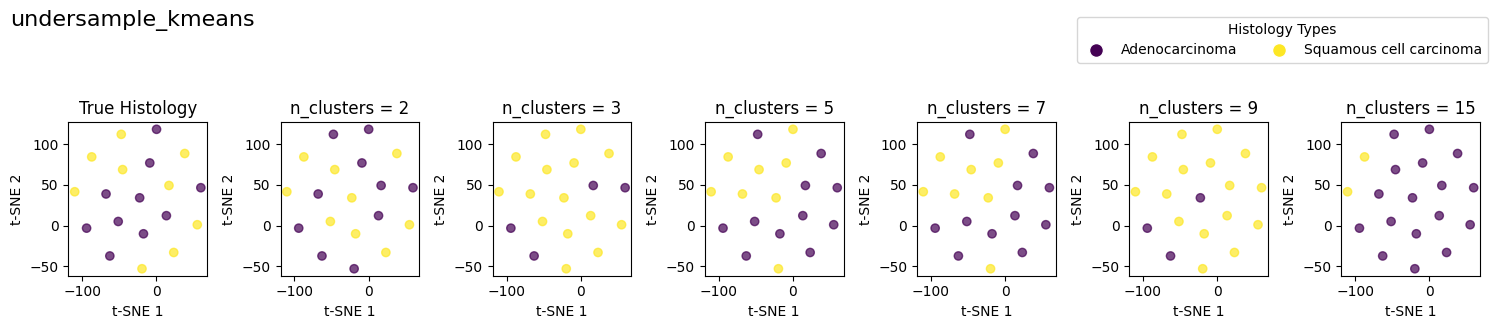


Running nmf with n_clusters=2 and undersample sampling...

Evaluating accuracy for nmf with n_clusters=2 and undersample sampling:
Train Accuracy: 0.5348837209302325, Test Accuracy: 0.47368421052631576, Mapping: ('Squamous cell carcinoma', 'Adenocarcinoma')

Running nmf with n_clusters=3 and undersample sampling...

Evaluating accuracy for nmf with n_clusters=3 and undersample sampling:
Train Accuracy: 0.5348837209302325, Test Accuracy: 0.3684210526315789, Mapping: ('Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma')

Running nmf with n_clusters=5 and undersample sampling...

Evaluating accuracy for nmf with n_clusters=5 and undersample sampling:
Train Accuracy: 0.5116279069767442, Test Accuracy: 0.5263157894736842, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma')

Running nmf with n_clusters=7 and undersample sampling...

Evaluating accuracy for nmf with n_clusters=7 and undersample sampling:
Train Accuracy: 0.581

/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence

Train Accuracy: 0.627906976744186, Test Accuracy: 0.5789473684210527, Mapping: ('Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma')

Running nmf with n_clusters=15 and undersample sampling...

Evaluating accuracy for nmf with n_clusters=15 and undersample sampling:


/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Train Accuracy: 0.6976744186046512, Test Accuracy: 0.5789473684210527, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Adenocarcinoma')


/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


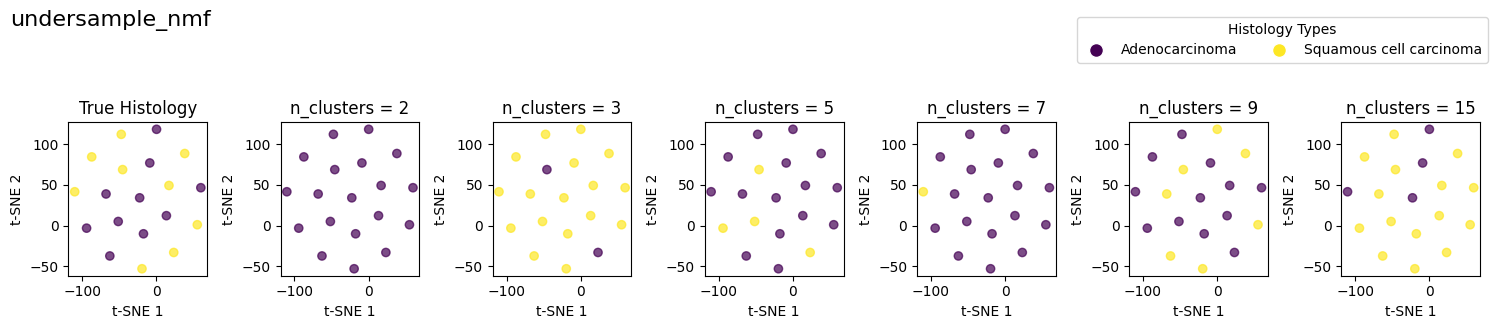


Running hierarchical with n_clusters=2 and undersample sampling...

Evaluating accuracy for hierarchical with n_clusters=2 and undersample sampling:
Train Accuracy: 0.5348837209302325, Test Accuracy: 0.5789473684210527, Mapping: ('Adenocarcinoma', 'Squamous cell carcinoma')

Running hierarchical with n_clusters=3 and undersample sampling...

Evaluating accuracy for hierarchical with n_clusters=3 and undersample sampling:
Train Accuracy: 0.6046511627906976, Test Accuracy: 0.42105263157894735, Mapping: ('Squamous cell carcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma')

Running hierarchical with n_clusters=5 and undersample sampling...

Evaluating accuracy for hierarchical with n_clusters=5 and undersample sampling:
Train Accuracy: 0.6046511627906976, Test Accuracy: 0.5263157894736842, Mapping: ('Adenocarcinoma', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma', 'Squamous cell carcinoma')

Running hierarchical with n_clusters=7 and undersample sampling...

Eva

/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/s_kim/.pyenv/versions/3.7.17/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


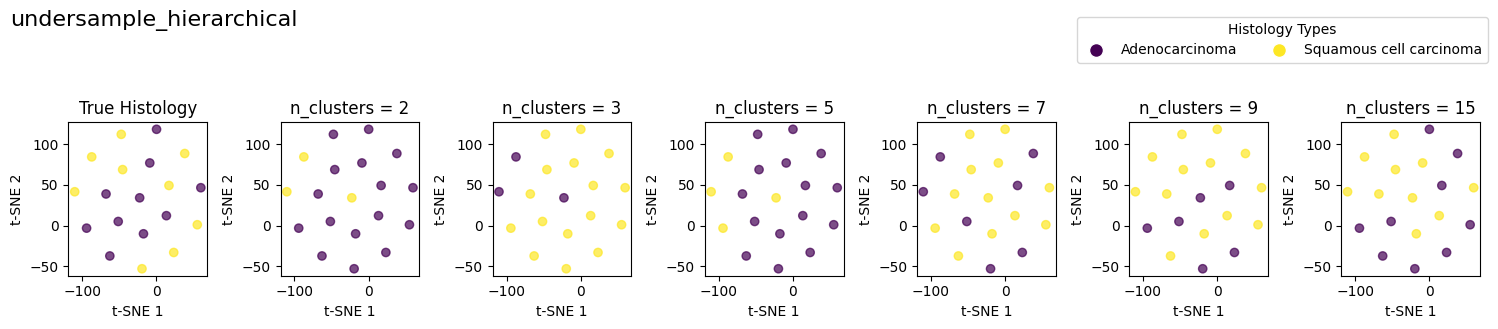


All accuracy results:
                            Train Accuracy Test Accuracy  \
none_kmeans_2                     0.693182      0.897436   
none_kmeans_3                     0.693182      0.897436   
none_kmeans_5                     0.795455      0.974359   
none_kmeans_7                     0.784091      0.820513   
none_kmeans_9                     0.727273      0.897436   
none_kmeans_15                    0.772727      0.923077   
none_nmf_2                        0.693182      0.897436   
none_nmf_3                        0.693182      0.897436   
none_nmf_5                        0.693182      0.897436   
none_nmf_7                        0.704545      0.897436   
none_nmf_9                        0.727273      0.897436   
none_nmf_15                       0.727273      0.897436   
none_hierarchical_2               0.693182      0.897436   
none_hierarchical_3               0.693182      0.897436   
none_hierarchical_5               0.761364      0.641026   
none_hierarchical

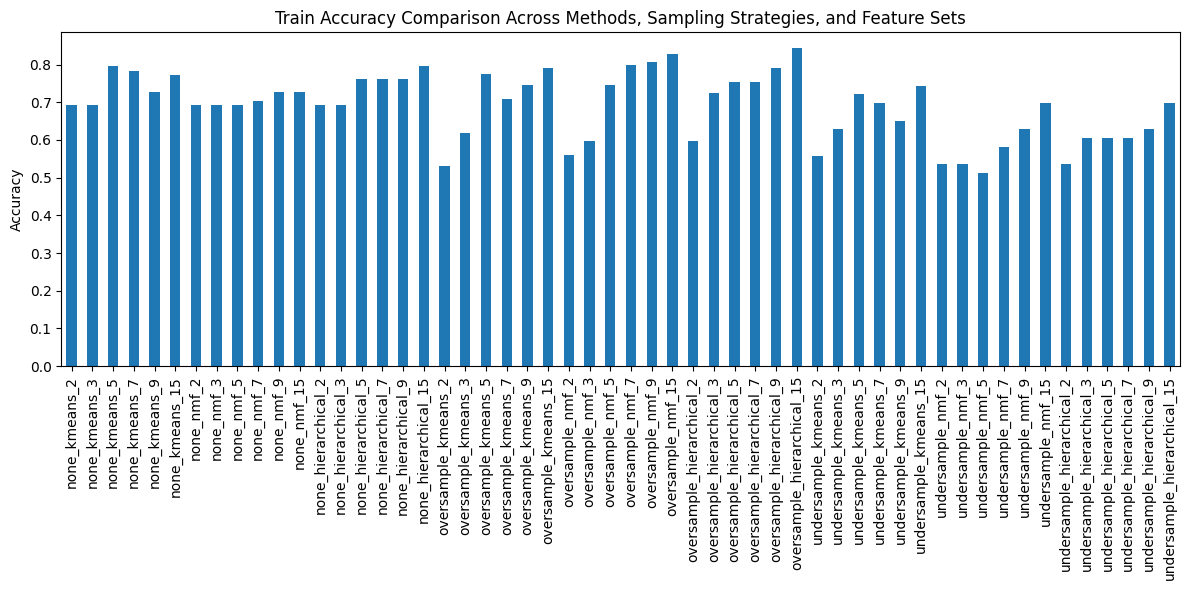

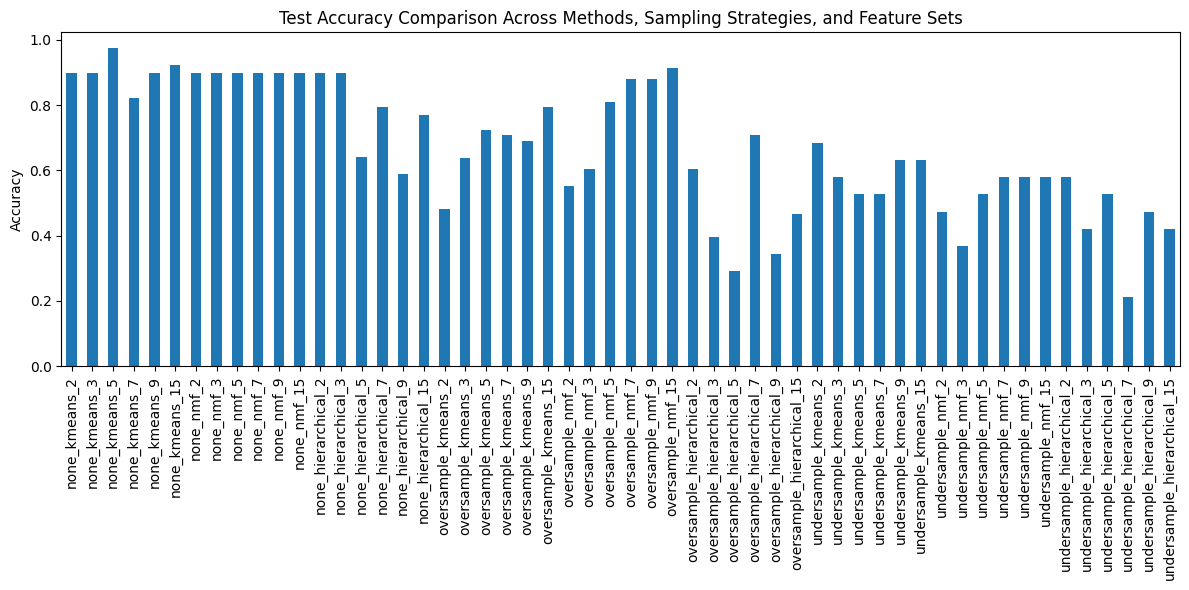

In [29]:
sfaf

In [30]:
results_df_sorted = results_df.sort_values(by='Test Accuracy', ascending=False)
results_df_sorted.head(30)

,Train Accuracy,Test Accuracy,Mapping
none_kmeans_5,0.795455,0.974359,"(Adenocarcinoma, Adenocarcinoma, Adenocarcinom..."
none_kmeans_15,0.772727,0.923077,"(Adenocarcinoma, Adenocarcinoma, Adenocarcinom..."
oversample_nmf_15,0.828358,0.913793,"(Adenocarcinoma, Squamous cell carcinoma, Squa..."
none_kmeans_2,0.693182,0.897436,"(Adenocarcinoma, Adenocarcinoma)"
none_kmeans_3,0.693182,0.897436,"(Adenocarcinoma, Adenocarcinoma, Adenocarcinoma)"
none_kmeans_9,0.727273,0.897436,"(Adenocarcinoma, Adenocarcinoma, Squamous cell..."
none_nmf_2,0.693182,0.897436,"(Adenocarcinoma, Adenocarcinoma)"
none_nmf_3,0.693182,0.897436,"(Adenocarcinoma, Adenocarcinoma, Adenocarcinoma)"
none_nmf_5,0.693182,0.897436,"(Adenocarcinoma, Adenocarcinoma, Adenocarcinom..."
none_nmf_7,0.704545,0.897436,"(Adenocarcinoma, Adenocarcinoma, Adenocarcinom..."


---
---
## **5. Discussion and Conclusions**

### **5.1. Performance Overview**

The results obtained above give several important insights about unsupervised learning approaches for NSCLC histology classification:

- **Best Performance**: 
    - Non-negative Matrix Factorization (NMF) with 15 clusters and SMOTE oversampling achieved the highest test accuracy (91.38%), outperforming other configurations when considering both train accuracy and baseline performance. 
    - K-means clustering with 5 clusters on the original imbalanced data also performed well with 97.44% test accuracy and 79.55% training accuracy. Despite the high baseline accuracy (89.74% test, 69.32% train), this configuration demonstrated substantial improvement over simply predicting the majority class.
- **Cluster Count Effect**: Training accuracy generally increases with cluster count due to the greater model flexibility provided by more granular partitioning.
- **Mapping Strategy Impact**: My approach of mapping multiple clusters to binary histology categories (adenocarcinoma vs. squamous cell carcinoma) allows unsupervised methods to capture more complex expression patterns while maintaining the unsupervised nature of cluster discovery.
- **Generalization Challenge**: Higher cluster counts do not consistently improve test accuracy, indicating potential overfitting with certain methods (particularly hierarchical clustering).

### **5.2. Analysis by Sampling Strategy**

#### 5.2.1. Original Imbalanced Data
- **Baseline Accuracy**: The class imbalance heavily favors adenocarcinoma, creating a high baseline test accuracy (89.74%) and train accuracy (69.32%) with all predicting as adenocarcinoma. This high baseline accuracies make performance evaluation challenging.
- **Top Performers**: K-means clustering with 5 clusters (97.44%) and 15 clusters (92.31%) exceeded the baseline on test data.
- **Training Accuracies**: Notably, training accuracies for these configurations were relatively modest (79.55% and 77.27% respectively), suggesting good generalization despite the imbalance.

#### 5.2.2. SMOTE Oversampling
- **Balanced Baseline**: With equal class distribution, the baseline accuracy is 50%.
- **Superior Performance**: NMF with 15 clusters demonstrated exceptional performance (91.38% test accuracy, 82.84% train accuracy).
- **Method Comparison**: While K-means and NMF maintained reasonable train-test accuracy gaps, hierarchical clustering exhibited severe overfitting with substantially lower test accuracies.

#### 5.2.3. Random Undersampling
- **Balanced Baseline**: Like oversampling, random undersampling creates a 50% baseline accuracy.
- **Reduced Effectiveness**: Models trained on undersampled data consistently showed lower accuracy on both training and test sets compared to other sampling strategies.
- **Overfitting Tendency**: Hierarchical clustering algorithms demonstrated particularly pronounced overfitting, with test accuracies substantially below training performance.

### **5.3. Methodological Implications**

These findings suggest that:
1. **Cluster Granularity Matters**: Using more clusters than class labels enables the capture of biologically relevant subgroups within histological categories.
2. **Sampling Strategy Impact**: Oversampling with SMOTE provides better model training conditions than either undersampling.
3. **Algorithm Selection**: NMF appears particularly well-suited for gene expression data, potentially due to its ability to identify meaningful biological patterns in non-negative data.

This semi-supervised framework successfully bridges purely unsupervised clustering with clinical classification, offering both biological insights and practical diagnostic potential.
